In this notebook we will train a VGG 16 model to classify a manta ray. 

In [27]:
import os
import random
import itertools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2

from sklearn.metrics import confusion_matrix, accuracy_score

from keras.callbacks import History 
history = History()

In [30]:
def wrap_generator(generator):
  '''Function to generate the second class. Since, we are dealing with a single mantaray class.
   0 is for noise and 1 for manta ray image.'''

  while True:
      x,y = next(generator)
      y = tf.keras.utils.to_categorical(y)
      zeros = tf.zeros_like(y) + tf.constant([1.,0.])
      y = tf.concat([y,zeros], axis=0)
      
      yield x,y

In [31]:
train_datagen = ImageDataGenerator()
pred_datagen = ImageDataGenerator()

In [32]:
# change as you want
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
TRAIN_DIR = '/content/drive/MyDrive/data_folder/train_data'
VALI_DIR = '/content/drive/MyDrive/data_folder/val_data'
LR = 1e-4
SEED = 77

In [36]:
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [37]:
train_generator = train_datagen.flow_from_directory(
            directory = TRAIN_DIR,
            target_size = IMAGE_SIZE,
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = True,
            seed = SEED,
            classes = ['mantaray']
    )

Found 2839 images belonging to 1 classes.


In [38]:
pred_generator = pred_datagen.flow_from_directory(
            VALI_DIR,
            target_size = IMAGE_SIZE,
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = True,
            seed = SEED,
            classes = ['mantaray','not_manta']
)

Found 1953 images belonging to 2 classes.


Here the other class is just background images.

In [41]:
def custom_model(ct=True):

  pre_process = tf.keras.layers.Lambda(preprocess_input)
  vgg = tf.keras.applications.VGG16(weights = 'imagenet', include_top = True, input_shape = IMAGE_SIZE + (3,))
  vgg = tf.keras.Model(vgg.input, vgg.layers[-3].output)
  vgg.trainable = False
  
  inp = tf.keras.Input(IMAGE_SIZE + (3,))
  vgg_16_process = pre_process(tf.keras.layers.GaussianNoise(0.1)(inp))
  vgg_out = vgg(vgg_16_process)
  
  noise = tf.keras.layers.Lambda(tf.zeros_like)(vgg_out)
  noise = tf.keras.layers.GaussianNoise(0.1)(noise)

  if ct:
      x = tf.keras.layers.Lambda(lambda z: tf.concat(z, axis=0))([vgg_out,noise])
      x = tf.keras.layers.Activation('relu')(x)
  else:
      x = vgg_out
      
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  out = tf.keras.layers.Dense(2, activation='softmax')(x)

  model = tf.keras.Model(inp, out)
  model.compile(tf.keras.optimizers.Adam(learning_rate=LR), loss='binary_crossentropy')
  
  return model

In [42]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=5)

model = custom_model()
model.fit(wrap_generator(train_generator), steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=7, callbacks=[history])

Epoch 1/7
88/88 [==============================] - 197s 2s/step - loss: 0.2380
Epoch 2/7
88/88 [==============================] - 188s 2s/step - loss: 0.0382
Epoch 3/7
88/88 [==============================] - 191s 2s/step - loss: 0.0119
Epoch 4/7
88/88 [==============================] - 191s 2s/step - loss: 0.0046
Epoch 5/7
88/88 [==============================] - 197s 2s/step - loss: 0.0022
Epoch 6/7
88/88 [==============================] - 202s 2s/step - loss: 0.0014
Epoch 7/7
88/88 [==============================] - 226s 3s/step - loss: 0.0010


In [47]:
history.history

{'loss': [0.23795777559280396,
  0.03820056840777397,
  0.011900760233402252,
  0.004630424547940493,
  0.0022097087930887938,
  0.0013834715355187654,
  0.0010216424707323313]}

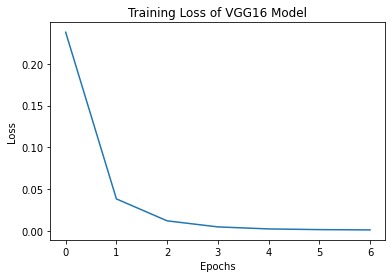

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of VGG16 Model')
plt.show()

Now let us perform inference.

In [53]:
model.save('my_custom_vgg_model.h5')

In [54]:
# !cp /content/my_custom_vgg_model.h5 /content/drive/MyDrive/models

Now, let us test on test set. This code takes a lot of time to run, because, inference using VGG is slow, therefore thank you for your patience. The group is trying to optimize this by using tensors, and loading the entire dataset into memory, and that work is in progress.

In [56]:
test_num = pred_generator.samples

label_test = []

for i in range((test_num // pred_generator.batch_size)+1):
    X,y = pred_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape

(1953,)

In [58]:
ineference_model = custom_model(ct=False)
ineference_model.set_weights(model.get_weights())

In [60]:
pred_test = np.argmax(ineference_model.predict(pred_generator), axis=1)

In [62]:
# We need to flip the prediction because, we have considered 1 as manta and 0 as not manta.
pred_test = np.where(pred_test==1,0,1)

In [70]:
print(f'TEST ACCURACY: {(accuracy_score(label_test, pred_test)* 100):.2f} %')

TEST ACCURACY: 64.31 %


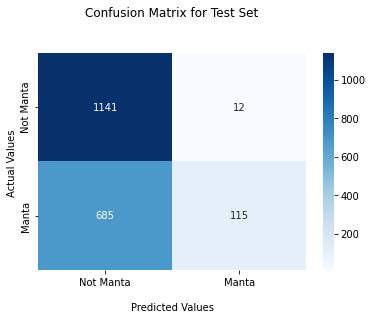

In [74]:
import seaborn as sns
cf_matrix = confusion_matrix(label_test, pred_test)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix for Test Set\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not Manta','Manta'])
ax.yaxis.set_ticklabels(['Not Manta','Manta'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [77]:
predict_proba = ineference_model.predict(pred_generator)

In the end the total GPU usuage was 13GB, and exceeding this causes the notebook to crash. 